In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms

from tencmnist_dataset import CMNIST10
from cmnist_dataset import CMNIST
from utils import *

# CMNIST

In [2]:
# If you haven't read the CMNIST docstring, here it is! :)
print(CMNIST.__doc__)


    A class to create and manage Colored MNIST datasets with environmental factors.

    This class partitions the MNIST dataset into subsets for different environments,
    with user-defined probabilities of flipping (label-based) image colors.

    Args:
        root (str): Directory path to save or load the MNIST data.
        download (bool, optional): If True, download MNIST if not present. Default is True.
        sizes (tuple[int] | tuple[float], optional): Sizes of subsets for each environment.
            - If integers, each value specifies the number of samples in an environment.
            - If floats, they represent percentages of the dataset and must sum to 1.
            Default is (0.4, 0.4, 0.2).
        e_s (tuple[float], optional): Environment probabilities for flipping colors. Default is (0.1, 0.3, 0.9).
        train (bool, optional): Use the training or test split of MNIST. Default is True.
        shuffle (bool, optional): Shuffle the dataset before partitioning

## Creating Training and Test Environments for CMNIST Dataset

In [3]:
torch.manual_seed(42)

cmnist = CMNIST(r"C:\Users\Asus\Documents\Code\Towards Environment Invariant Representation Learning\data", 
                download=True, 
                sizes=(0.5, 0.5),
                e_s=(0.1, 0.4),
                train=True,
                shuffle=True,
                p_flip_label=0.25,
                downsample=False)

cmnist_test = CMNIST(r"C:\Users\Asus\Documents\Code\Towards Environment Invariant Representation Learning\data", 
                download=True, 
                sizes=(1.0, ),
                e_s=(0.9, ),
                train=False,
                shuffle=False,
                p_flip_label=0.25,
                downsample=False)

train_environments_datasets = cmnist.create_environments()
test_environment_dataset = cmnist_test.create_environments()

**When calling `create_environments()` with `combine_datasets=False` (which is the `default`), the method returns a list of environment-specific datasets. Each dataset corresponds to one environment and contains its respective samples.**

In [4]:
print(train_environments_datasets)
print(test_environment_dataset)

[<cmnist_dataset.CMNISTDataset object at 0x00000243BCA5AF90>, <cmnist_dataset.CMNISTDataset object at 0x00000243BCAF66F0>]


In [5]:
train_dataloader = DataLoader(train_environments_datasets[0], batch_size=4)

for data, targets, envs in train_dataloader:
    print(data.shape)
    print(targets)
    print(envs)
    break

torch.Size([4, 2, 28, 28])
tensor([0., 0., 1., 0.])
tensor([0, 0, 0, 0])


### Visualizing Training and Testing Environments

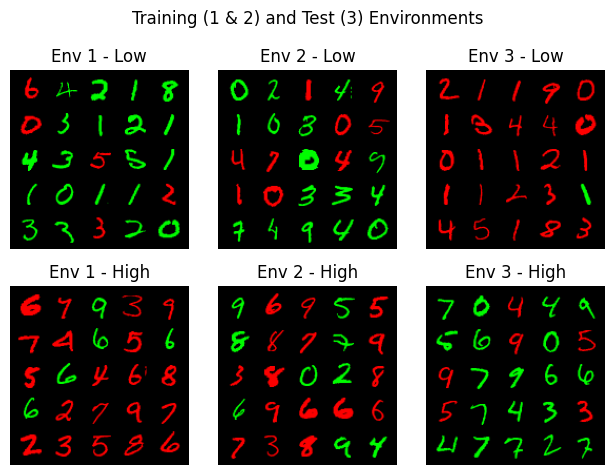

In [6]:
environments_datasets = train_environments_datasets + test_environment_dataset

for environment, environment_dataset in enumerate(environments_datasets):
    mask = (environment_dataset[:][1] == 0).squeeze()

    high_numbers = environment_dataset[:][0][mask]
    low_numbers = environment_dataset[:][0][~mask]

    high_samples = make_grid([i for i in high_numbers[:25]], 5, 5)
    low_samples = make_grid([i for i in low_numbers[:25]], 5, 5)

    plt.subplot(2, 3, 1+environment)
    show_image(low_samples.cpu())
    plt.title(f'Env {environment+1} - Low')

    plt.subplot(2, 3, 4+environment)
    show_image(high_samples.cpu())
    plt.title(f'Env {environment+1} - High')
    plt.tight_layout()

    plt.suptitle('Training (1 & 2) and Test (3) Environments')

## `combine_datasets = True`

In [7]:
torch.manual_seed(42)

transform = transforms.Compose([transforms.CenterCrop(16)])

cmnist = CMNIST(r"C:\Users\Asus\Documents\Code\Towards Environment Invariant Representation Learning\data", 
                download=True, 
                sizes=(0.25, 0.25, 0.25, 0.25),
                e_s=(0.1, 0.2, 0.0, 0.4),
                train=True,
                shuffle=True,
                p_flip_label=0.25,
                transform=transform,
                downsample=False)

In [8]:
torch.manual_seed(42)

datasets = cmnist.create_environments()
dataset = datasets[0]
print(dataset[0][0].shape, dataset[0][1], dataset[0][2], sep='  |  ')

torch.Size([2, 16, 16])  |  tensor(0.)  |  0


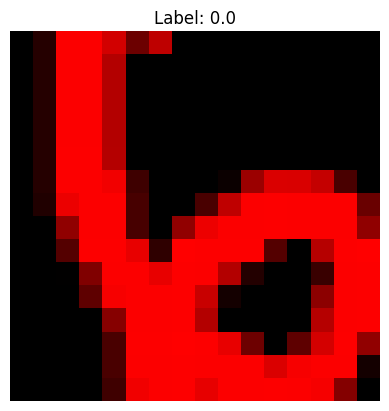

In [9]:
torch.manual_seed(42)

dataset = cmnist.create_environments(combine_datasets=True)
print(dataset)

i=2
show_image(dataset[i][0], dataset[i][1])

# 10CMNIST 

In [10]:
print(CMNIST10.__doc__)


    Custom Dataset class to create 10CMNIST.
    Each digit class is assigned a unique color for the training set.
    In the test set, digits are colored with a random color that is not their associated label's color.

    Args:
        root (str): Directory path to save or load the MNIST data.
        download (bool, optional): If True, download MNIST if not present. Default is True.
        colors (tuple[tuples], optional): A tuples of RGB color values corresponding to each digit class (0-9).
        train (bool, optional): Use the training or test split of MNIST. Default is True.
        transform (torch.nn.Module, optional): Optional transformations for MNIST images. Default is None.
        downsample (bool, optional): If True, downsample MNIST images from 28x28 to
                                     14x14. Default is True.

    Caution:
        - Note that only the red and green channels are used for colorization in this implementation.
        - The blue channel is not utiliz

In [11]:
transform = transforms.Compose([transforms.CenterCrop(16)])

train_10cmnnist = CMNIST10(r"C:\Users\Asus\Documents\Code\Towards Environment Invariant Representation Learning\data", 
                           train=True, 
                           downsample=False,
                           transform=transform)
test_10cmnist = CMNIST10(r"C:\Users\Asus\Documents\Code\Towards Environment Invariant Representation Learning\data", 
                         train=False, 
                         downsample=False)

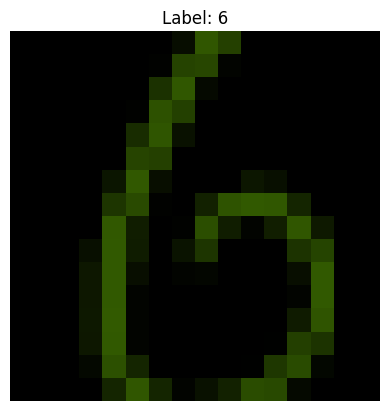

In [12]:
i = 18
image, label = train_10cmnnist[i][0], train_10cmnnist[i][1]
show_image(image, label=label)

In [13]:
train_samples = get_n_samples_per_class(train_10cmnnist, n=5)
test_samples = get_n_samples_per_class(test_10cmnist, n=5)

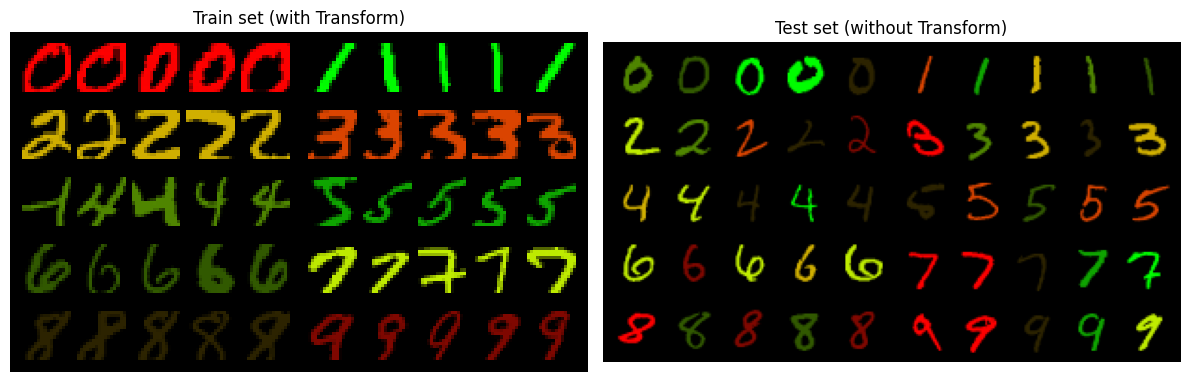

In [14]:
train_samples_grid = make_grid([make_grid(samples) for samples in train_samples], 2)
test_samples_grid = make_grid([make_grid(samples) for samples in test_samples], 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
show_image(train_samples_grid)
plt.title('Train set (with Transform)')

plt.subplot(1, 2, 2)
show_image(test_samples_grid)
plt.title('Test set (without Transform)')

plt.tight_layout()
plt.show()

In [15]:
train_dataloader = DataLoader(train_10cmnnist, batch_size=16)

for data, target in train_dataloader:
    print(data.shape)
    print(target)
    break

torch.Size([16, 2, 16, 16])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7])
